# Exploration 17: cGAN
---

#### Model
* Conditional Generative Adversarial Nets (cGAN)

#### Data
* cityscapes

#### Goals
* data augmentation
* build U-Net generator and discriminator
* run more than 10 epochs

---

## Importing Dependencies

In [1]:
import os, cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# data augmentation
from tensorflow import image, data
from tensorflow.keras.preprocessing.image import random_rotation

#model
from tensorflow.keras import layers, Input, Model, losses, optimizers

print('all done!')

all done!


## Loading Data

In [3]:
train_path = os.getenv('HOME')+'/aiffel/cityscapes/train/'
print('the number of train examples:', len(os.listdir(train_path)))

the number of train examples: 1000


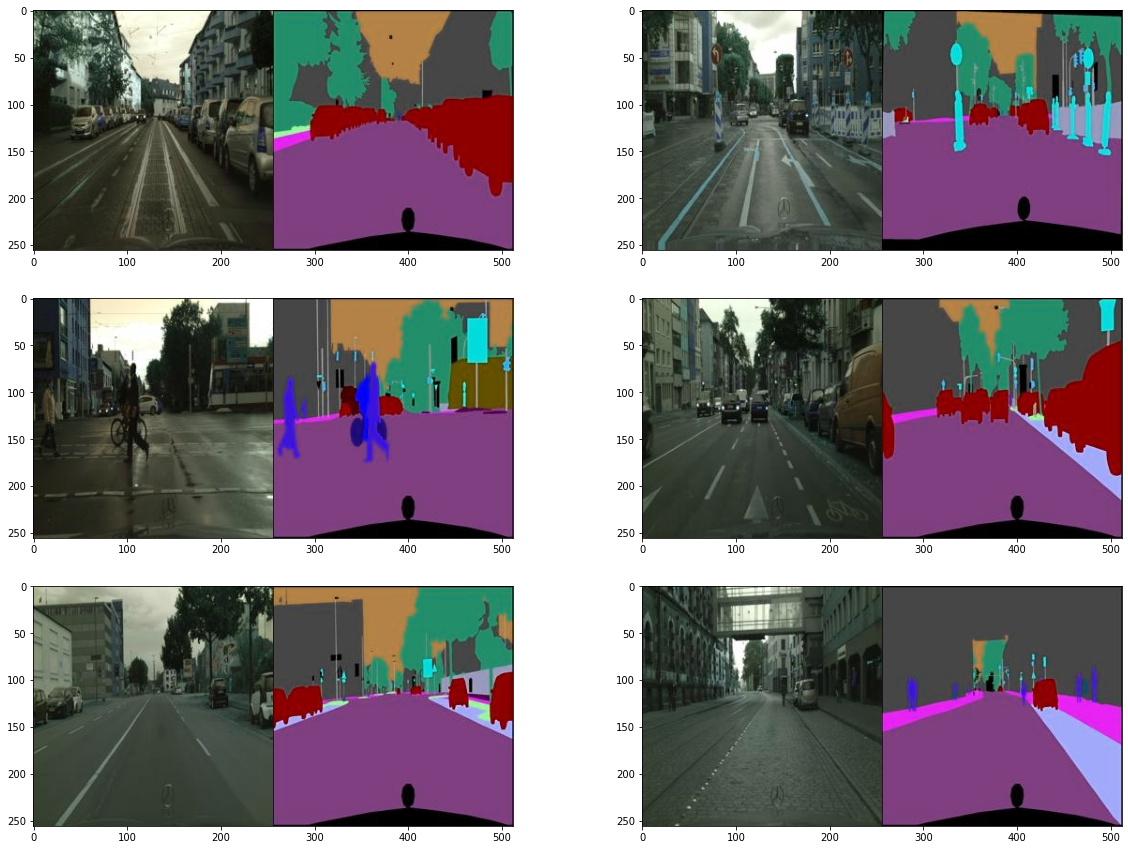

In [4]:
plt.figure(figsize=(20, 15))
for i in range(1, 7):
  f = train_path + os.listdir(train_path)[np.random.randint(1000)]
  img = cv2.imread(f, cv2.IMREAD_COLOR)
  plt.subplot(3, 2, i)
  plt.imshow(img)

will be using the image on the right (segmentation map) to create image on the left

In [5]:
# size check
f = train_path + os.listdir(train_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


#### Split Image

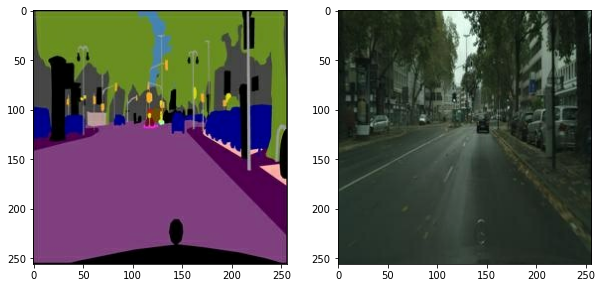

In [6]:
def normalize(x):
  x = tf.cast(x, tf.float32)
  return(x/127.5) - 1

def denormalize(x):
  x = (x+1)*127.5
  x = x.numpy()
  return x.astype(np.uint8)

def load_img(img_path):
  img = tf.io.read_file(img_path)
  img = tf.image.decode_image(img, 3)

  w = tf.shape(img)[1] // 2
  ground_truth = img[:, :w, :]
  ground_truth = tf.cast(ground_truth, tf.float32)
  input_image = img[:, w:, :]
  input_image = tf.cast(input_image, tf.float32)
  return normalize(input_image), normalize(ground_truth)

f = train_path + os.listdir(train_path)[1]
input_image, ground_truth = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(input_image))
plt.subplot(1,2,2); plt.imshow(denormalize(ground_truth))


## Data Augmentation

In [7]:
@tf.function()
def apply_augmentation(sketch, colored):
    # concat by channel (3 channel imgs to 6 channel)
    stacked = tf.concat([sketch, colored], axis=-1)
    # 50% refection padding or 30 pixels pad width for constant padding
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)
    # random crop    
    out = image.random_crop(padded, size=[256, 256, 6])
    # 50% chance of flipping
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    # 50% chance of rotating
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]

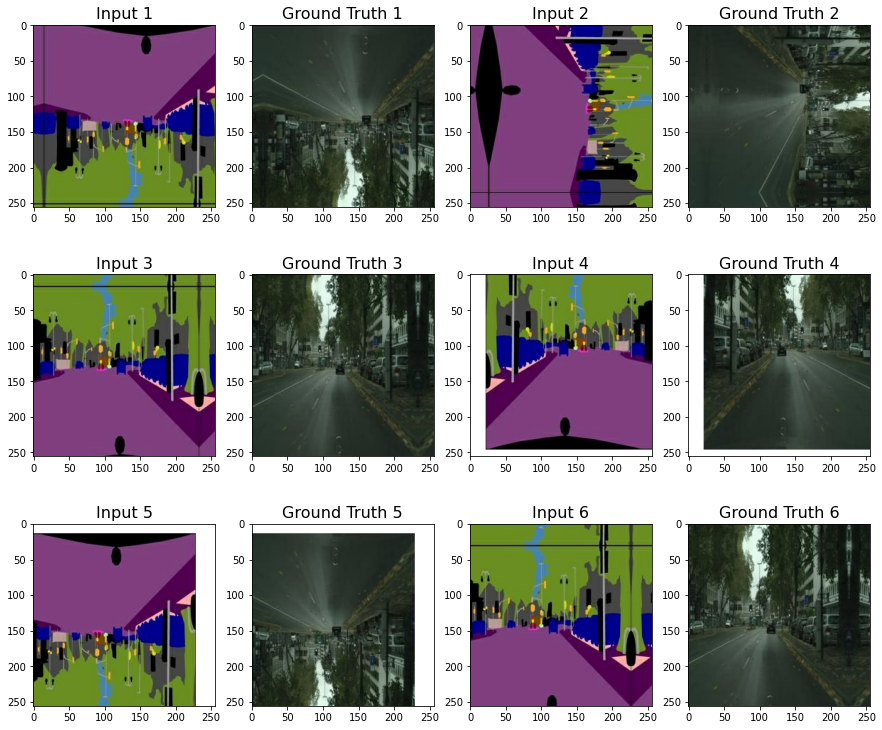

In [8]:
plt.figure(figsize=(15, 13))
img_n = 1
for i in range(1, 13, 2):
  augmented_input, augmented_gt = apply_augmentation(input_image, ground_truth)

  plt.subplot(3, 4, i);
  plt.imshow(denormalize(augmented_input)); plt.title(f'Input {img_n}', fontsize=16)
  plt.subplot(3, 4, i+1);
  plt.imshow(denormalize(augmented_gt)); plt.title(f'Ground Truth {img_n}', fontsize=16)
  img_n += 1

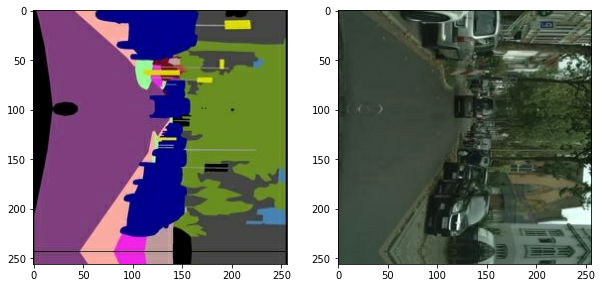

In [9]:
def get_train(img_path):
  input_image, ground_truth = load_img(img_path)
  input_image, ground_truth = apply_augmentation(input_image, ground_truth)
  return input_image, ground_truth

train_images = data.Dataset.list_files(train_path + '*.jpg')
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
input_image, ground_truth = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(input_image[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(ground_truth[0].astype(np.uint8))

## Generator
U-Net Generator

In [10]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [11]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [12]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

## Discriminator

In [13]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [14]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [15]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

## Train

In [16]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

# loss function for generator
def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

# loss function for discriminator
def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [17]:
#optimizer
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [18]:
@tf.function
def train_step(input_image, ground_truth):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator predict
        gen_output = generator(input_image, training=True)
        # Discriminator predict
        fake_disc = discriminator(input_image, gen_output, training=True)
        real_disc = discriminator(input_image, ground_truth, training=True)
        # Generator loss
        gene_loss, l1_loss = get_gene_loss(gen_output, ground_truth, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) # L1 loss λ=100
        # Discrminator loss
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [19]:
EPOCHS = 32

generator = UNetGenerator()
discriminator = Discriminator()
history = {'gen_loss':[], 'l1_loss':[], 'disc_loss':[]}

for epoch in range(1, EPOCHS+1):
  for i, (input_image, ground_truth) in enumerate(train_images):
    g_loss, l1_loss, d_loss = train_step(input_image, ground_truth)
    history['gen_loss'].append(g_loss)
    history['l1_loss'].append(l1_loss)
    history['disc_loss'].append(d_loss)

    if (i+1) % 200 == 0:
      print(f"EPOCH[{epoch}] - STEP[{i+1}] \
              \nGenerator_loss:{g_loss.numpy():.4f} \
              \nL1_loss:{l1_loss.numpy():.4f} \
              \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[200]               
Generator_loss:1.7534               
L1_loss:0.1948               
Discriminator_loss:0.5935

EPOCH[2] - STEP[200]               
Generator_loss:1.8202               
L1_loss:0.2146               
Discriminator_loss:0.3819

EPOCH[3] - STEP[200]               
Generator_loss:1.2787               
L1_loss:0.1945               
Discriminator_loss:0.6602

EPOCH[4] - STEP[200]               
Generator_loss:2.3955               
L1_loss:0.1704               
Discriminator_loss:1.0462

EPOCH[5] - STEP[200]               
Generator_loss:1.8492               
L1_loss:0.2309               
Discriminator_loss:0.2469

EPOCH[6] - STEP[200]               
Generator_loss:2.0835               
L1_loss:0.1810               
Discriminator_loss:0.6668

EPOCH[7] - STEP[200]               
Generator_loss:1.1696               
L1_loss:0.1503               
Discriminator_loss:0.6932

EPOCH[8] - STEP[200]               
Generator_loss:1.4651               
L1_loss:0.1917   

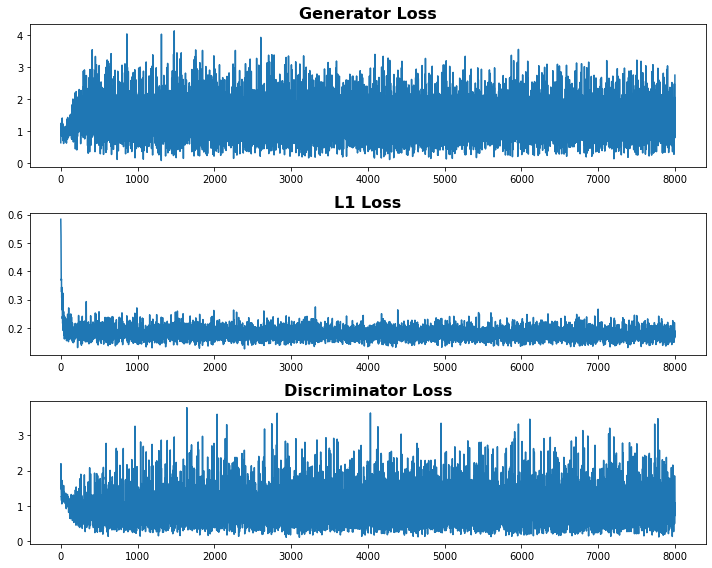

In [25]:
plt.figure(figsize=(10, 8))

plt.subplot(311)
plt.plot(history['gen_loss'])
plt.title('Generator Loss', fontsize=16, fontweight='bold')

plt.subplot(312)
plt.plot(history['l1_loss'])
plt.title('L1 Loss', fontsize=16, fontweight='bold')

plt.subplot(313)
plt.plot(history['disc_loss'])
plt.title('Discriminator Loss', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

## Test

In [26]:
test_path = os.getenv('HOME')+'/aiffel/cityscapes/val/'
print('the number of train examples:', len(os.listdir(test_path)))

the number of train examples: 5


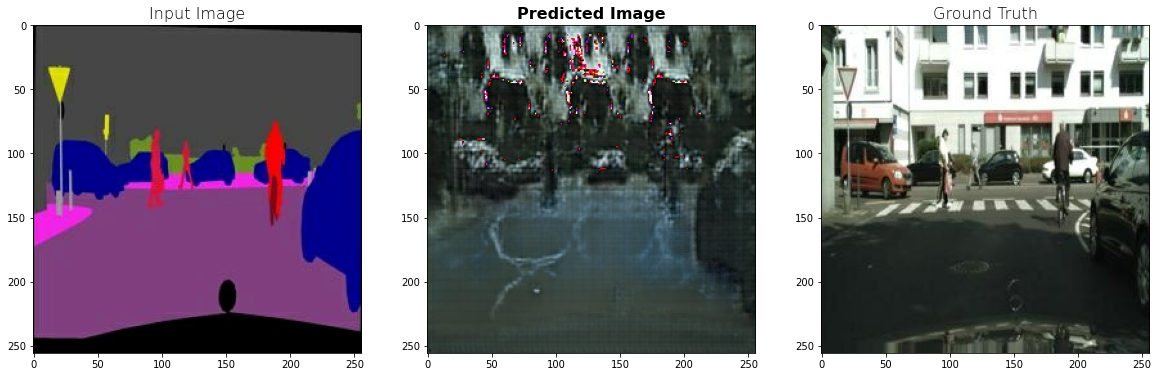

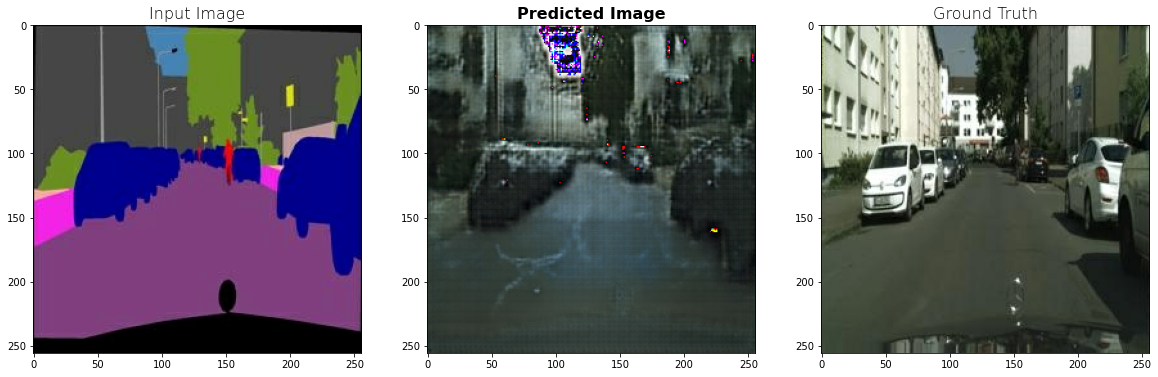

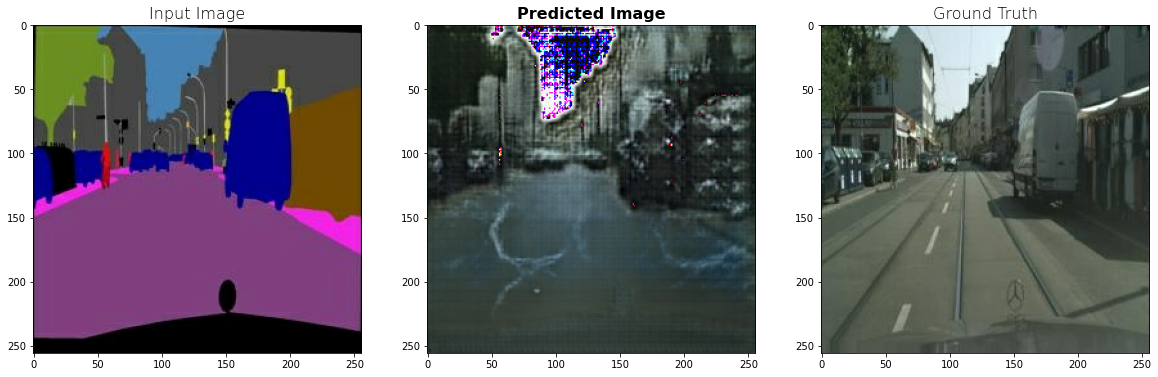

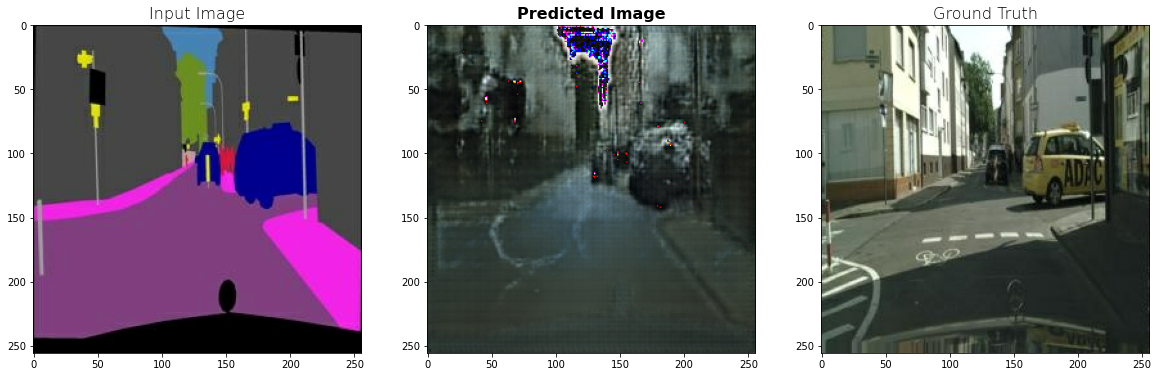

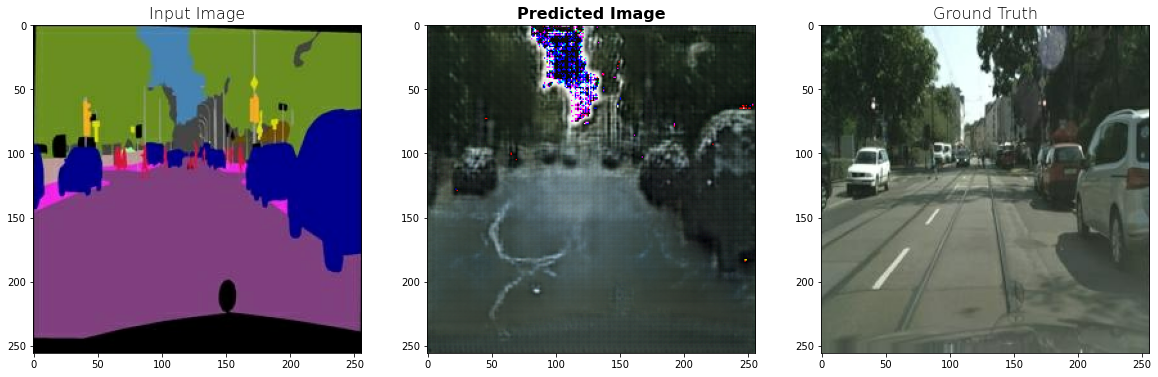

In [27]:
for i in range(5):
  f = test_path + os.listdir(test_path)[i]
  input_image, ground_truth = load_img(f)

  pred = generator(tf.expand_dims(input_image, 0))
  pred = denormalize(pred)

  plt.figure(figsize=(20, 10))
  plt.subplot(1,3,1); plt.imshow(denormalize(input_image)); plt.title('Input Image', fontsize=16, fontweight='light')
  plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image', fontsize=16, fontweight='bold')
  plt.subplot(1,3,3); plt.imshow(denormalize(ground_truth)); plt.title('Ground Truth', fontsize=16, fontweight='light')

---
## Conclusion

Since this is the last exploration, I wanted to put more time into it and hoped to bring meaningful results.<br/>
However, running epochs in Colab took forever. I mean FOREVER.<br/> 
It took more than 12 hours to run 25 epochs.<br/>
At first, I wanted to try 500 and 32 epochs and compare the results, but lost connection after 27 epochs.<br/>
I still haven't figured out what went wrong.
(Maybe something to do with Colab?)<br/>
Nonetheless, using GAN is always interesting.<br/>